In [1]:
# 1/20/2020 20 threads, 40G
    #csv: wall time: 7min 45s
    #dta: Wall time: 1h 3min 45s
    
# 1/21/2020 20 threads, 100G
    #csv: Wall time: 5min 48s
    #dta: Wall time: 37min 3s
    
# 1/21/2020 1:54PM, 20 threads, 100G
    #csv: Wall time: 8min 16s
    #dta: Wall time: 

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 20)
!date

Tue Feb 25 23:56:01 PST 2020


# 2010 census demo data; looking for the downward bias in DP counts that Akee found for AIAN population on reservations

Akee's talk here: https://vimeo.com/380264104

In [3]:
#0001–4999 Federally recognized American Indian reservation and/or off-reservation trust land
#5000–5499 Hawaiian home land 5500–5999 Oklahoma tribal statistical area
#5500–5999 Oklahoma tribal statistical area
#6000–7999 Alaska Native village statistical area
#8000–8999 Tribal designated statistical area
#9000–9499 State-recognized American Indian reservation
#9500–9998 State designated tribal statistical area 

In [4]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

race_cols = ['P0030005','P0060004'] # AIAN alone, AIAN combo
keep_cols = location_cols + race_cols

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','TBLGRP')):
        return True
    else:
        return (x in keep_cols)

In [5]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)

<string>:2: DtypeWarning: Columns (28,32,33) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 13min 56s, sys: 44.5 s, total: 14min 40s
Wall time: 15min 15s


In [81]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[-3:] = df_dp.columns[-3:] #coded vars are capitalized
dta_columns = dta_columns + ['aianhha'] 
dta_columns #check contents

['state',
 'county',
 'tract',
 'blkgrp',
 'block',
 'aianhh',
 'aianhhfp',
 'aianhhcc',
 'aitsce',
 'aits',
 'aitscc',
 'ttract',
 'aianhhns',
 'aitsns',
 'aianhhsc',
 'P0010001',
 'P0030005',
 'P0060004',
 'aianhha']

In [83]:
%%time

r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta',
                 chunksize=1, convert_missing=True, preserve_dtypes=False)

df_sf_aianhha = pd.DataFrame()
for t in r:
    print('.', flush=True, end=' ')
    df_sf_aianhha = df_sf_aianhha.append(t)
    break
df_sf_aianhha.shape

. CPU times: user 16.3 s, sys: 88 ms, total: 16.4 s
Wall time: 17.1 s


(1, 9060)

In [88]:
for x in df_sf_aianhha.columns:
    if  x.startswith("aian"):
        print(x)

aianhh
aianhhfp
aianhhcc
aianhhns
aianhhsc


In [7]:
%%time

#r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
#                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

#df_sf_aianhha = pd.DataFrame()
#for t in r:
#    print('.', flush=True, end=' ')
#    df_sf_aianhha = df_sf_aianhha.append(t)
#df_sf_aianhha.shape

#saved AIAN-relevant vars here; loads faster than the .dta
df_sf = pd.read_csv('/home/j/temp/beatrixh/2020_census/all50states_AIAN_sf.csv')

<string>:2: DtypeWarning: Columns (7,10,11) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 20.7 s, sys: 1.8 s, total: 22.5 s
Wall time: 23.5 s


In [8]:
#df_sf.to_csv(r'/home/j/temp/beatrixh/all50states_AIAN_sf.csv', index = None, header=True)

In [9]:
df_sf.columns = [x.upper() for x in df_sf.columns]
df_sf.shape

(11071790, 18)

In [10]:
#store columns by type
float_cols = list(df_dp.loc[:, df_dp.dtypes == np.float64].columns)
int_cols = df_dp.loc[:, df_dp.dtypes == np.int64].columns

#conver df_sf to correct dtypes
df_sf.loc[:,float_cols] = df_sf.loc[:,float_cols].astype(np.float64)
df_sf.loc[:,int_cols] = df_sf.loc[:,int_cols].astype(np.int64)

#check
df_sf.dtypes

STATE         int64
COUNTY      float64
TRACT       float64
BLKGRP      float64
BLOCK       float64
AIANHH      float64
AIANHHFP    float64
AIANHHCC     object
AITSCE      float64
AITS        float64
AITSCC       object
TTRACT       object
AIANHHNS    float64
AITSNS      float64
AIANHHSC    float64
P0010001      int64
P0030005      int64
P0060004      int64
dtype: object

In [11]:
left = df_sf[location_cols + race_cols + ['P0010001']]
df = pd.merge(left[(left.BLOCK != '')], df_dp.dropna(subset=['BLOCK']), left_on=location_cols, right_on=location_cols, suffixes=('_SF', '_DP'))
df

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,STATE,COUNTY,TRACT,BLKGRP,BLOCK,P0030005_SF,P0060004_SF,P0010001_SF,AIANHH,AIANHHFP,...,AITSCE,AITS,AITSCC,TTRACT,AIANHHNS,AITSNS,AIANHHSC,P0010001_DP,P0030005_DP,P0060004_DP
0,2,13.0,100.0,1.0,1363.0,5,0,24,9999.0,99999.0,...,999.0,99999.0,99,999999,99999999.0,99999999.0,NaN,87,0,42
1,2,13.0,100.0,1.0,1366.0,0,0,0,9999.0,99999.0,...,999.0,99999.0,99,999999,99999999.0,99999999.0,NaN,0,0,0
2,2,13.0,100.0,1.0,1369.0,0,0,0,9999.0,99999.0,...,999.0,99999.0,99,999999,99999999.0,99999999.0,NaN,0,0,0
3,2,13.0,100.0,1.0,1370.0,0,0,0,6030.0,1095.0,...,999.0,99999.0,99,999999,2418758.0,99999999.0,NaN,0,0,0
4,2,13.0,100.0,1.0,1371.0,438,27,942,6030.0,1095.0,...,999.0,99999.0,99,999999,2418758.0,99999999.0,NaN,988,361,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11071785,56,45.0,951100.0,1.0,1868.0,0,0,0,9999.0,99999.0,...,999.0,99999.0,99,999999,99999999.0,99999999.0,NaN,0,0,0
11071786,56,45.0,951100.0,1.0,1869.0,0,0,0,9999.0,99999.0,...,999.0,99999.0,99,999999,99999999.0,99999999.0,NaN,0,0,0
11071787,56,45.0,951100.0,1.0,1870.0,0,0,0,9999.0,99999.0,...,999.0,99999.0,99,999999,99999999.0,99999999.0,NaN,0,0,0
11071788,56,45.0,951100.0,1.0,1871.0,0,0,0,9999.0,99999.0,...,999.0,99999.0,99,999999,99999999.0,99999999.0,NaN,0,0,0


In [132]:
fed_res.columns
max(res_test['P0030005_SF'])

5038

In [64]:
# AIANNHA

res_test = fed_res.groupby(['AIANHH'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())
res_test.columns

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


Index(['P0030005_SF', 'P0030005_DP', 'P0060004_SF', 'P0060004_DP',
       'P0010001_SF', 'P0010001_DP'],
      dtype='object')

In [116]:
# AIANNHA

res_test_state = fed_res.groupby(['AIANHH','STATE'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())
res_test_state.columns

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


Index(['P0030005_SF', 'P0030005_DP', 'P0060004_SF', 'P0060004_DP',
       'P0010001_SF', 'P0010001_DP'],
      dtype='object')

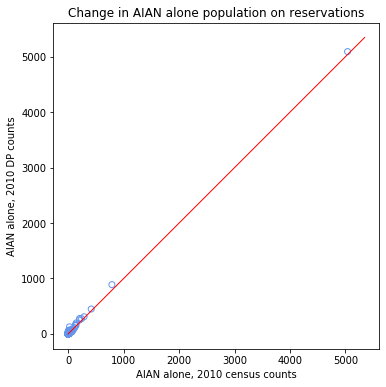

In [118]:
x = res_test_state[["P0030005_SF"]]
y = res_test_state[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone, 2010 census counts')
plt.ylabel('AIAN alone, 2010 DP counts')
plt.title('Change in AIAN alone population on reservations')

plt.show()

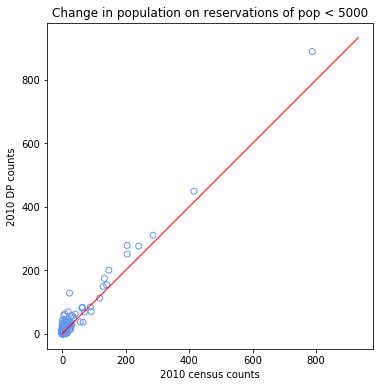

In [123]:
x = res_test_state[(res_test_state.P0030005_SF < 5e3) ][["P0030005_SF"]]
y = res_test_state[(res_test_state.P0030005_SF < 5e3) ][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 census counts')
plt.ylabel('2010 DP counts')
plt.title('Change in population on reservations of pop < 5000')

plt.show()

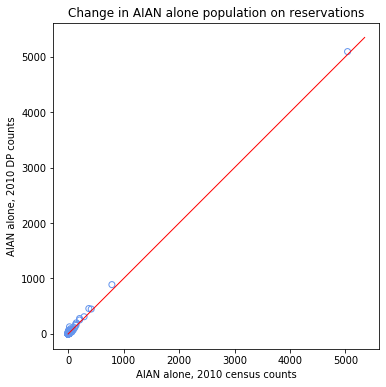

In [107]:
x = res_test[["P0030005_SF"]] #this is counts aggregated per reservation, SF
y = res_test[["P0030005_DP"]] #this is counts aggregated per reservation, DP

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone, 2010 census counts')
plt.ylabel('AIAN alone, 2010 DP counts')
plt.title('Change in AIAN alone population on reservations')

plt.show()

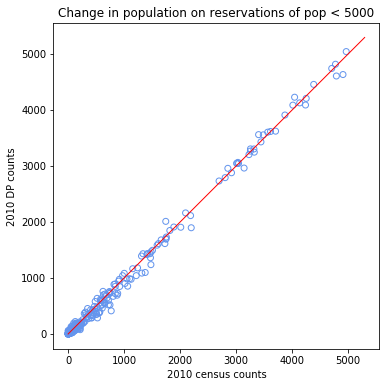

In [115]:
x = res_test[(res_test.P0010001_SF < 5e3) ][["P0010001_SF"]]
y = res_test[(res_test.P0010001_SF < 5e3) ][["P0010001_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 census counts')
plt.ylabel('2010 DP counts')
plt.title('Change in population on reservations of pop < 5000')

plt.show()

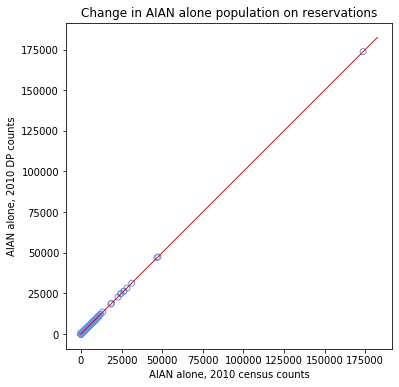

In [91]:
x = res_test[["P0010001_SF"]]
y = res_test[["P0010001_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone, 2010 census counts')
plt.ylabel('AIAN alone, 2010 DP counts')
plt.title('Change in AIAN alone population on reservations')

plt.show()

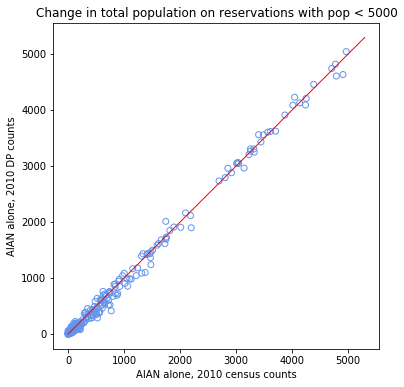

In [106]:
x = res_test[(res_test.P0010001_SF < 5e3) | (res_test.P0010001_DP < 5e3)][["P0010001_SF"]]
y = res_test[(res_test.P0010001_SF < 5e3) | (res_test.P0010001_DP < 5e3)][["P0010001_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone, 2010 census counts')
plt.ylabel('AIAN alone, 2010 DP counts')
plt.title('Change in total population on reservations with pop < 5000')

plt.show()

In [102]:
res_test['abs_diff'] = res_test['P0030005_DP'] - res_test['P0030005_SF']
res_test['pct_diff'] = res_test['P0030005_DP'] / res_test['P0030005_SF']
res_test[res_test.P0030005_SF!=0][['P0030005_SF','P0030005_DP','abs_diff','pct_diff']].describe()

,P0030005_SF,P0030005_DP,abs_diff,pct_diff
count,153.000000,153.000000,153.000000,153.000000
mean,60.908497,70.614379,9.705882,3.090922
std,413.885955,420.064016,19.887143,4.815294
min,1.000000,0.000000,-30.000000,0.000000
25%,1.000000,2.000000,-1.000000,0.545455
50%,4.000000,11.000000,4.000000,1.333333
75%,16.000000,28.000000,16.000000,3.125000
max,5038.000000,5092.000000,105.000000,28.000000


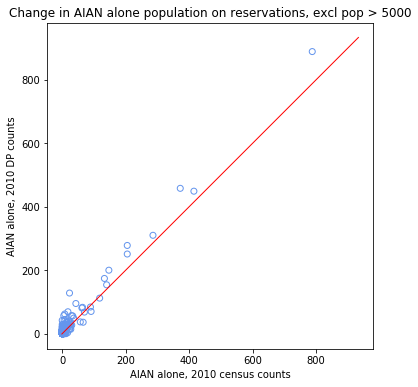

In [74]:
x = res_test[(res_test.P0030005_SF < 800) | (res_test.P0030005_DP < 800)][["P0030005_SF"]]
y = res_test[(res_test.P0030005_SF < 800) | (res_test.P0030005_DP < 800)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone, 2010 census counts')
plt.ylabel('AIAN alone, 2010 DP counts')
plt.title('Change in AIAN alone population on reservations, excl pop > 5000')

plt.show()

In [12]:
fed_res = df[(df.AIANHH<5000)].copy(deep=True)

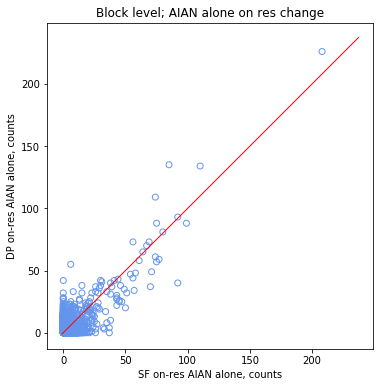

In [13]:
#block level

x = fed_res[["P0030005_SF"]]
y = fed_res[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF on-res AIAN alone, counts')
plt.ylabel('DP on-res AIAN alone, counts')
plt.title('Block level; AIAN alone on res change')

plt.show()

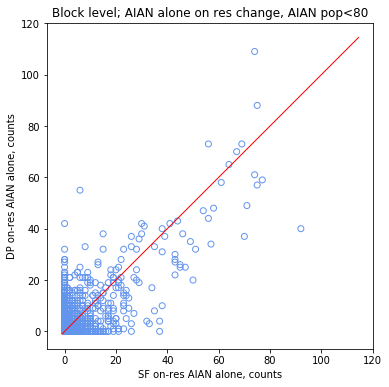

In [14]:
#zooming in more
x = fed_res[(fed_res.P0030005_SF<80) | (fed_res.P0030005_DP<80)][["P0030005_SF"]]
y = fed_res[(fed_res.P0030005_SF<80) | (fed_res.P0030005_DP<80)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF on-res AIAN alone, counts')
plt.ylabel('DP on-res AIAN alone, counts')
plt.title('Block level; AIAN alone on res change, AIAN pop<80')

plt.show()

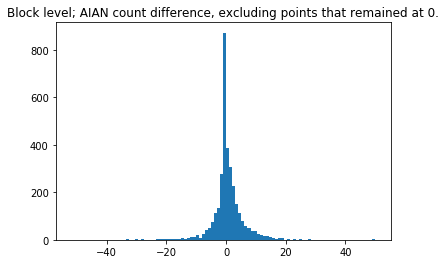

In [15]:
#block level difference hist, excluding all points that remained at 0
fed_res['abs_diff'] = fed_res['P0030005_DP'] - fed_res['P0030005_SF']

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(fed_res[(fed_res.P0030005_DP!=0) | (fed_res.P0030005_SF!=0)].abs_diff, bins = 100)

plt.title('Block level; AIAN count difference, excluding points that remained at 0.')

plt.show() 

In [16]:
fed_res.abs_diff.describe()

count    166472.000000
mean          0.011227
std           0.799559
min         -52.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          50.000000
Name: abs_diff, dtype: float64

In [17]:
fed_res[fed_res.abs_diff!=0].abs_diff.describe()

count    3240.000000
mean        0.576852
std         5.703567
min       -52.000000
25%        -2.000000
50%        -1.000000
75%         3.000000
max        50.000000
Name: abs_diff, dtype: float64

In [20]:
# excluding AIAN on-res 0s that stayed 0s, looking at blocks with <80 AIAN
fed_res[((fed_res.P0030005_DP!=0) | (fed_res.P0030005_SF!=0)) & (fed_res.P0030005_SF<80) | (fed_res.P0030005_DP<80)]['abs_diff'].describe()

count    166466.000000
mean          0.010729
std           0.786235
min         -52.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          49.000000
Name: abs_diff, dtype: float64

In [23]:
fed_res['abs_dif'] = (fed_res['P0030005_DP']) - (fed_res['P0030005_SF'])
fed_res[(fed_res.P0030005_DP!=0) | (fed_res.P0030005_SF!=0)]['abs_dif'].describe()

count    3280.000000
mean        0.569817
std         5.669026
min       -52.000000
25%        -2.000000
50%        -1.000000
75%         3.000000
max        50.000000
Name: abs_dif, dtype: float64

In [24]:
res_tract = fed_res.groupby(['STATE','COUNTY','TRACT'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())
res_tract

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


P0030005_SF  P0030005_DP  P0060004_SF  P0060004_DP  \
STATE COUNTY TRACT                                                          
1     51.0   30800.0             0            0            0            0   
      53.0   970400.0            0            0          216          185   
             970500.0            0            0            0            0   
      99.0   76100.0             0            0            0            0   
      101.0  5408.0              0            0            0            0   
...                            ...          ...          ...          ...   
56    13.0   940202.0            7           12         3039         2988   
             940300.0           22           14          912          903   
             940400.0           26           15          480          456   
             940500.0            2            6          366          408   
      17.0   967900.0            0            0           16           12   

                       P0010001_SF  P0010001_DP  
STATE COUNTY TRACT                               
1     51.0   30800.0             1           10  
      53.0   970400.0          282          335  
             970500.0            0            0  
      99.0   76100.0             0            0  
      101.0  5408.0              0           16  
...                            ...          ...  
56    13.0   940202.0         4832         4846  
             940300.0         5515         5457  
             940400.0         5565         5491  
             940500.0         2575         2587  
      17.0   967900.0          160          214  

[943 rows x 6 columns]

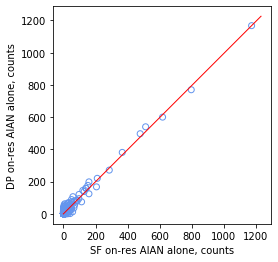

In [25]:
x = res_tract[["P0030005_SF"]]
y = res_tract[["P0030005_DP"]]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')


ratio = 1
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)
#ax.axis([0,xright,0,top])

plt.xlabel('SF on-res AIAN alone, counts')
plt.ylabel('DP on-res AIAN alone, counts')

plt.show()

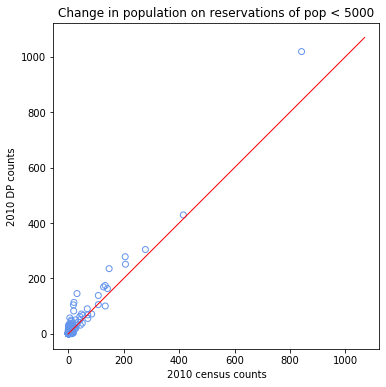

In [130]:
x = res_county[(res_county.P0030005_SF < 5e3) ][["P0030005_SF"]]
y = res_county[(res_county.P0030005_SF < 5e3) ][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 census counts')
plt.ylabel('2010 DP counts')
plt.title('Change in population on reservations of pop < 5000')

plt.show()

In [34]:
res_state = fed_res.groupby(['STATE'])['P0030005_SF','P0030005_DP',
                                                 'P0060004_SF','P0060004_DP',
                                                 'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


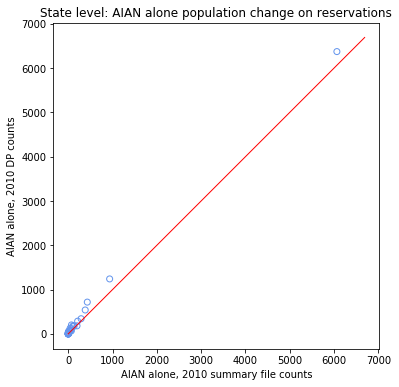

In [45]:
x = res_state[["P0030005_SF"]]
y = res_state[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone, 2010 summary file counts')
plt.ylabel('AIAN alone, 2010 DP counts')
plt.title('State level: AIAN alone population change on reservations')

plt.show()

In [26]:
res_county = fed_res.groupby(['STATE','COUNTY'])['P0030005_SF','P0030005_DP',
                                                 'P0060004_SF','P0060004_DP',
                                                 'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


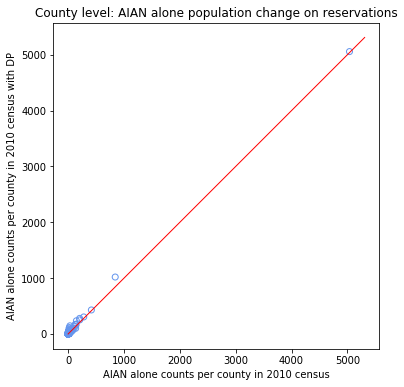

In [55]:
x = res_county[["P0030005_SF"]]
y = res_county[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone counts per county in 2010 census')
plt.ylabel('AIAN alone counts per county in 2010 census with DP')
plt.title('County level: AIAN alone population change on reservations')

plt.show()

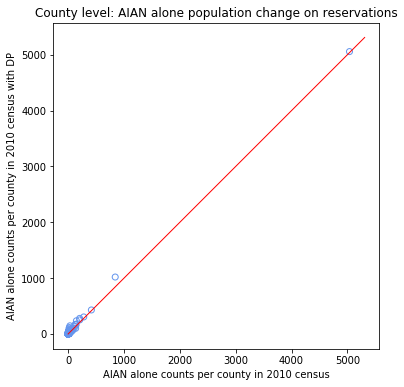

In [58]:
x = res_county[(res_county.P0030005_SF<2e5) | (res_county.P0030005_DP<2e5)][["P0030005_SF"]]
y = res_county[(res_county.P0030005_SF<2e5) | (res_county.P0030005_DP<2e5)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('AIAN alone counts per county in 2010 census')
plt.ylabel('AIAN alone counts per county in 2010 census with DP')
plt.title('County level: AIAN alone population change on reservations')

plt.show()

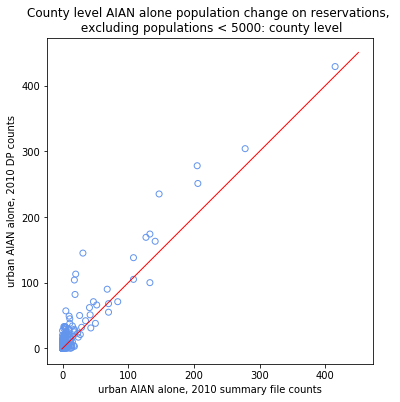

In [48]:
x = res_county[(res_county.P0030005_SF<600) | (res_county.P0030005_DP<600)][["P0030005_SF"]]
y = res_county[(res_county.P0030005_SF<600) | (res_county.P0030005_DP<600)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('urban AIAN alone, 2010 summary file counts')
plt.ylabel('urban AIAN alone, 2010 DP counts')
plt.title('County level AIAN alone population change on reservations, \n \
excluding populations < 5000: county level')

plt.show()

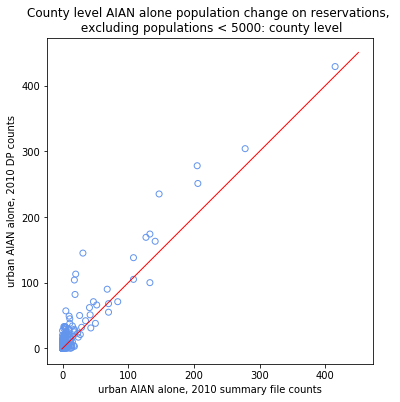

In [31]:
x = res_county[(res_county.P0030005_SF<800) & (res_county.P0030005_DP<800)][["P0030005_SF"]]
y = res_county[(res_county.P0030005_SF<800) & (res_county.P0030005_DP<800)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('urban AIAN alone, 2010 summary file counts')
plt.ylabel('urban AIAN alone, 2010 DP counts')
plt.title('County level AIAN alone population change on reservations, \n \
excluding populations < 5000: county level')

plt.show()

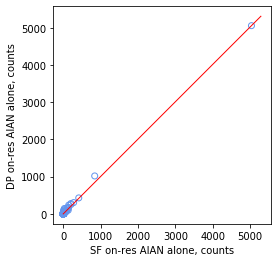

In [35]:
x = res_county[["P0030005_SF"]]
y = res_county[["P0030005_DP"]]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')


ratio = 1
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)
#ax.axis([0,xright,0,top])

plt.xlabel('SF on-res AIAN alone, counts')
plt.ylabel('DP on-res AIAN alone, counts')

plt.show()

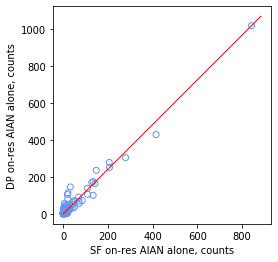

In [36]:
x = res_county[(res_county.P0030005_SF<4000) | (res_county.P0030005_DP<4000)][["P0030005_SF"]]
y = res_county[(res_county.P0030005_SF<4000) | (res_county.P0030005_DP<4000)][["P0030005_DP"]]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')


ratio = 1
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)
#ax.axis([0,xright,0,top])

plt.xlabel('SF on-res AIAN alone, counts')
plt.ylabel('DP on-res AIAN alone, counts')

plt.show()

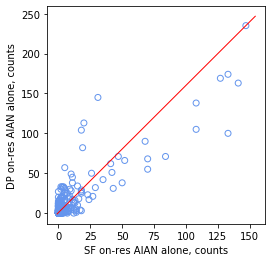

In [37]:
x = res_county[(res_county.P0030005_SF<200) | (res_county.P0030005_DP<200)][["P0030005_SF"]]
y = res_county[(res_county.P0030005_SF<200) | (res_county.P0030005_DP<200)][["P0030005_DP"]]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')


ratio = 1
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)
#ax.axis([0,xright,0,top])

plt.xlabel('SF on-res AIAN alone, counts')
plt.ylabel('DP on-res AIAN alone, counts')

plt.show()

In [38]:
# check out difference, county level, of dp and sf, aian alone on reservation
res_county['abs_diff'] = (res_county['P0030005_DP']) - (res_county['P0030005_SF'])
res_county[(res_county.P0030005_DP!=0) | (res_county.P0030005_SF!=0)]['abs_diff'].describe()

count    196.000000
mean       9.535714
std       21.945474
min      -33.000000
25%       -1.000000
50%        3.000000
75%       12.250000
max      177.000000
Name: abs_diff, dtype: float64

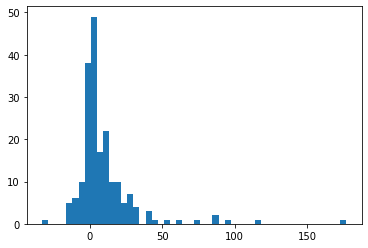

In [39]:
# distribution of difference, county level, aian alone on reservation
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(res_county[((res_county.P0030005_DP!=0) | (res_county.P0030005_SF!=0))].abs_diff, bins = 50)

plt.title("county level distribution of dp-sf difference, excluding all zeros that remained 0")

plt.show() 

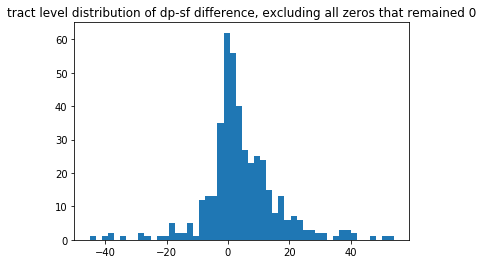

In [44]:
res_tract['abs_diff'] = res_tract['P0030005_DP'] - res_tract['P0030005_SF']
# distribution of difference, county level, aian alone on reservation, missing all instances of 0-->0
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(res_tract[((res_tract.P0030005_DP!=0) | (res_tract.P0030005_SF!=0))].abs_diff, bins = 50)

plt.title("tract level distribution of dp-sf difference, excluding all zeros that remained 0")

plt.show() 